In [31]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, gc, os, glob
sys.path.append('/Users/earnric/Google Drive/ASU/Codes/PythonCode/modules')

import matplotlib as mpl
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import NullFormatter
import numpy as np
from IPython import display

from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import astropy 

import pandas as pd

#new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
#              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
#              '#bcbd22', '#17becf']

import seaborn as sns
# sns.set(color_codes=True)
sns.set(style="whitegrid", font_scale=2.5, color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})

plt.rcParams['figure.figsize'] = (13,11)
plt.rcParams.update({'font.size': 32, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

pd.set_option('precision', 5)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
np.set_printoptions(linewidth=150)

In [10]:
def log_formatter(x,pos):
    return format(np.log10(x), '.0f')
logfmt  = FuncFormatter(log_formatter)

def log_GHzFormatter(x,pos):
    return format(np.log10(x)-9.0, '.0f')
logGHzfmt  = FuncFormatter(log_GHzFormatter)

def GHzFormatter(x,pos):
    return format(x/1e9, '.2e')
GHzfmt  = FuncFormatter(GHzFormatter)

def mic_formatter(x,pos):
    return format(x/10000., '.1f')
micfmt  = FuncFormatter(mic_formatter)

nullfmt = NullFormatter()
labelsize = 24

In [11]:
def dec(x):
    return r"{:d}".format(int(x))

def float1(x):
    return r"{:.1f}".format(x)

def float3(x):
    return r"{:.3f}".format(x)



In [12]:
#
# Convert flux into magnitude, no extinction...
#
ABref = 48.6
def mag(flux):
    """Convert flux into magnitude, no extinction"""
    return -2.5 * np.log10(flux) - ABref # (1+z) there since I forgot it in flux computation.

def compMags(dir,z):
    """Convert observed magnitude to Absolute"""
    # See notebook for calculation: D = m_ab - M_ab
    cDM = 2.5*np.log10((1.0+z)**-1*(cosmo.luminosity_distance(z).to(u.pc)/(10.0 * u.pc))**2) 

    print("Convert to Abs Mag. DM = {:.2f} @ z={:.1f}".format(cDM,z))
    absMag   = mag(haloData[dir][z]['1500A'])-cDM
    pop3Mag  = mag(haloData[dir][z]['1500A_P3'])-cDM
    nmAbsMag = mag(haloData[dir][z]['1500A_NM'])-cDM
    return absMag, pop3Mag,nmAbsMag


def getMag(Mags,z):
    """Convert Absolute magnitude to observational at z"""
    cDM = 2.5*np.log10((1.0+z)**-1*(cosmo.luminosity_distance(z).to(u.pc)/(10.0 * u.pc))**2) 
    return Mags + cDM


def getHaloMasses(dir,z):
    return haloData[dir][z]['MstarMsun']

def getHaloP3Masses(dir,z):
    return haloData[dir][z]['M3StarMsun']

def getHaloRadii(dir,z):
    return haloData[dir][z]['r_v']

# Load Data

In [13]:
# Load the raw halos that have DM masses ... these are not used directly for the LM compuation
# since they haven't been processed by finalizeDenPro2.py where we look for observationally 
# distinguishable galaxies. However, we can get a DM mass for a given stellar mass using these
# galaxies... 

dmMasses={}
runs = ['fw1','Z-4','Z-6','p3SN','fid']
for name, rootPath in zip(runs, ['./fw1/','./Z-4/','./Z-6/','./p3SN/','../12Mpc-n1.0-eps01-fek1-del200-rb300-newICs/']):
    filePat = 'stellar_DM_masses_z_[0-9]*.[05].txt' 
    files   = glob.glob(rootPath+filePat)  
    fileListz = []
    for file in files:
        start = file.index('z_') + 2
        end = len(file) - 4
        fileListz.append(file[start:end])
    # We now have all the z's for the halo files
    massFiles = {float(filez):  np.genfromtxt(file, delimiter=',',names=True) for filez,file in zip(fileListz,files)}
    dmMasses[name] = massFiles
    print(name, fileListz)
    
# dmMasses has flux and DM Mass info for all of the RAW halos... 
# We'll use these to find DM masses based on Stellar mass

fw1 ['10.0', '11.0', '12.0', '13.0', '14.0', '15.0', '16.0', '7.0', '8.0', '9.0']
Z-4 ['10.0', '11.0', '12.0', '13.0', '14.0', '15.0', '16.0', '7.0', '8.0', '9.0']
Z-6 ['10.0', '11.0', '12.0', '13.0', '14.0', '15.0', '16.0', '7.0', '8.0', '9.0']
p3SN ['10.0', '11.0', '12.0', '13.0', '14.0', '15.0', '16.0', '7.0', '8.0', '9.0']
fid ['10.0', '11.0', '12.0', '13.0', '14.0', '15.0', '16.0', '7.0', '8.0', '9.0']


In [14]:
haloData={}
runs = ['fid','fw1','Z-4','Z-6','p3SN']
for name, rootPath in zip(runs, ['../12Mpc-n1.0-eps01-fek1-del200-rb300-newICs/','./fw1/','./Z-4/','./Z-6/','./p3SN/']):
    filePat = 'haloFluxes_UV_z_[0-9]*.[05].txt' 
    files   = glob.glob(rootPath+filePat)  
    fileListz = []
    for file in files:
        start = file.index('z_') + 2
        end = len(file) - 4
        fileListz.append(file[start:end])
    fluxes = {float(filez):  np.genfromtxt(file, delimiter=',',names=True) for filez,file in zip(fileListz,files)}
    print(files,"\n",fileListz)
    haloData[name] = fluxes
    


['../12Mpc-n1.0-eps01-fek1-del200-rb300-newICs/haloFluxes_UV_z_10.0.txt', '../12Mpc-n1.0-eps01-fek1-del200-rb300-newICs/haloFluxes_UV_z_11.0.txt', '../12Mpc-n1.0-eps01-fek1-del200-rb300-newICs/haloFluxes_UV_z_12.0.txt', '../12Mpc-n1.0-eps01-fek1-del200-rb300-newICs/haloFluxes_UV_z_13.0.txt', '../12Mpc-n1.0-eps01-fek1-del200-rb300-newICs/haloFluxes_UV_z_14.0.txt', '../12Mpc-n1.0-eps01-fek1-del200-rb300-newICs/haloFluxes_UV_z_15.0.txt', '../12Mpc-n1.0-eps01-fek1-del200-rb300-newICs/haloFluxes_UV_z_16.0.txt', '../12Mpc-n1.0-eps01-fek1-del200-rb300-newICs/haloFluxes_UV_z_7.0.txt', '../12Mpc-n1.0-eps01-fek1-del200-rb300-newICs/haloFluxes_UV_z_8.0.txt', '../12Mpc-n1.0-eps01-fek1-del200-rb300-newICs/haloFluxes_UV_z_9.0.txt'] 
 ['10.0', '11.0', '12.0', '13.0', '14.0', '15.0', '16.0', '7.0', '8.0', '9.0']
['./fw1/haloFluxes_UV_z_10.0.txt', './fw1/haloFluxes_UV_z_11.0.txt', './fw1/haloFluxes_UV_z_12.0.txt', './fw1/haloFluxes_UV_z_13.0.txt', './fw1/haloFluxes_UV_z_14.0.txt', './fw1/haloFluxes_UV_

In [15]:
fileListz,files,haloData['fid'][9].dtype.names # Ensure they match up...

(['10.0', '11.0', '12.0', '13.0', '14.0', '15.0', '16.0', '7.0', '8.0', '9.0'],
 ['./p3SN/haloFluxes_UV_z_10.0.txt',
  './p3SN/haloFluxes_UV_z_11.0.txt',
  './p3SN/haloFluxes_UV_z_12.0.txt',
  './p3SN/haloFluxes_UV_z_13.0.txt',
  './p3SN/haloFluxes_UV_z_14.0.txt',
  './p3SN/haloFluxes_UV_z_15.0.txt',
  './p3SN/haloFluxes_UV_z_16.0.txt',
  './p3SN/haloFluxes_UV_z_7.0.txt',
  './p3SN/haloFluxes_UV_z_8.0.txt',
  './p3SN/haloFluxes_UV_z_9.0.txt'],
 ('halo',
  'r_v',
  'ZZsun',
  'ZPZsun',
  'MstarMsun',
  'M3StarMsun',
  'M3YngMsun',
  '1500A',
  '1500A_P3',
  '1500A_NM',
  '1500A_P3NM',
  '1500A_10pc',
  '1500A_P3_10pc'))

In [16]:
sorted(haloData['fid'].keys())

[7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0]

## Build dicts for the fraction of stars formed in Pop III dominated halos

In [17]:
haloData['fid'].keys()

dict_keys([16.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0])

In [18]:
#
# Build a dict of f_III/f_tot ratios for all galaxies
#
p3mf = {dir: {i:haloData[dir][i]['M3StarMsun']/haloData[dir][i]['MstarMsun'] for i in sorted(haloData[dir].keys())} for dir in runs}
# Build a dict of obs mag_AB for all galaxies 
mags = {dir: {i: mag(haloData[dir][i]['1500A']) for i in sorted(haloData[dir].keys())} for dir in runs}

# Some for the uncorrected Pop III flux... and mag... 
p3ffNM = {dir: {i:haloData[dir][i]['M3StarMsun']/haloData[dir][i]['MstarMsun'] for i in sorted(haloData[dir].keys())} for dir in runs}
magsNM = {dir: {i: mag(haloData[dir][i]['1500A_NM']) for i in sorted(haloData[dir].keys())} for dir in runs}

simVol = (12/0.71)**3 # Mpc

## Compute the Pop III flux fraction, errors data and other useful info... 

In [19]:
# Condition -- Pop III mass-fraction in the halo is at least 'frac'
def p3Halos(dir, p3mf, z, frac):
    return ((p3mf[dir][z] >= frac))
def regHalos(dir, p3mf, z, frac):
    return ((p3mf[dir][z] < frac))


def pop3_mass_frac(p3mf,runs,frac):
    pop3_mass_fracs = {}
    star_masses = {}
    for dir in runs:
        thezs = sorted(haloData[dir].keys())
        pop3StarsHalosIndxs  = {i: np.where(p3mf[dir][i] >= frac) for i in thezs} # indices of Pop III halos with high fraction of Pop III mass
        regStarsHalosIndxs   = {i: np.where(p3mf[dir][i] < frac) for i in thezs}  # indices of non Pop III halos
        
        numP3Halos           = {i: p3mf[dir][i][p3mf[dir][i] >= frac].size for i in thezs} # Number of halos dominated by Pop III mass
        numHalos             = {i: p3mf[dir][i].size for i in thezs}
        
        pop3Halo_P3_mass     = {i: np.sum(haloData[dir][i]['M3StarMsun'][pop3StarsHalosIndxs[i][0]]) for i in thezs} # Mass of Pop 3 stars in P3 halos
        pop3Halo_pol_mass    = {i: np.sum(haloData[dir][i]['MstarMsun'][pop3StarsHalosIndxs[i][0]]) - 
                                          np.sum(haloData[dir][i]['M3StarMsun'][pop3StarsHalosIndxs[i][0]]) for i in thezs} # Mass of Pop 2 in P3 halos
        P3StellarMass       = {i: haloData[dir][i]['M3StarMsun'].sum()  for i in thezs}
        totStellarMass      = {i: haloData[dir][i]['MstarMsun'].sum()  for i in thezs}
#         pop3StarsInHalos = {i: p3mf[dir][i][p3Halos(dir,p3mf,i,0.90)] for i in thezs}

        
        pop3_mass_fracs[dir] = numP3Halos, numHalos # Create a dictionary of the FRACTION of Pop III Bright galaxies at each redshift
        star_masses[dir] = P3StellarMass, totStellarMass
    return pop3_mass_fracs, star_masses # Return value one is by galaxy count, 2 is by mass


In [20]:
p3,sm = pop3_mass_frac(p3mf,runs,0.90)

In [21]:
p3['fid'][0][9]/p3['fid'][1][9]

0.25296068214116535

In [22]:
p3['fid'][0][8]/p3['fid'][1][8]

0.049221275345283574

In [23]:
#
# Compute the mean fraction of Pop III dominated halos averaged as a funciton of z
# Note we are NOT counting across all z, then averaging. We are averaging the ratios at EACH z
#

print("Average fraction of Pop III dominated halos (by mass) at z=9:",np.array([p3[dir][0][9]/p3[dir][1][9] for dir in runs]).mean())
print("Average fraction of Pop III dominated halos (by mass) at z=8:",np.array([p3[dir][0][8]/p3[dir][1][8] for dir in runs]).mean())


Average fraction of Pop III dominated halos (by mass) at z=9: 0.23990077683329378
Average fraction of Pop III dominated halos (by mass) at z=8: 0.044052027899444804


In [24]:
#
# Compute the mean fraction of Pop III dominated halos averaged as a funciton of z
# Note we are NOT counting across all z, then averaging. We are averaging the ratios at EACH z
# IGNORE P3SN
#

print("Average fraction of Pop III dominated halos (by mass) at z=9:",np.array([p3[dir][0][9]/p3[dir][1][9] for dir in ['fid','fw1','Z-4','Z-6']]).mean())
print("Average fraction of Pop III dominated halos (by mass) at z=8:",np.array([p3[dir][0][8]/p3[dir][1][8] for dir in ['fid','fw1','Z-4','Z-6']]).mean())


print("P3SN fraction of Pop III dominated halos (by mass) at z=9:",np.array([p3[dir][0][9]/p3[dir][1][9] for dir in ['p3SN']]).mean())
print("P3SN fraction of Pop III dominated halos (by mass) at z=8:",np.array([p3[dir][0][8]/p3[dir][1][8] for dir in ['p3SN']]).mean())


Average fraction of Pop III dominated halos (by mass) at z=9: 0.24845007108836803
Average fraction of Pop III dominated halos (by mass) at z=8: 0.05191725488755981
P3SN fraction of Pop III dominated halos (by mass) at z=9: 0.20570359981299674
P3SN fraction of Pop III dominated halos (by mass) at z=8: 0.012591119946984758


In [25]:
sm['fid'][0][9]/sm['fid'][1][9],sm['fid'][0][8]/sm['fid'][1][8]

(0.03697757380989322, 0.04866648501822436)

In [26]:
haloData['fid'][9]['M3StarMsun'].sum() / haloData['fid'][9]['MstarMsun'].sum() 

0.03697757380989322

In [27]:
haloData['fid'][8]['M3StarMsun'].sum() / haloData['fid'][8]['MstarMsun'].sum() 

0.04866648501822436

In [28]:
data_set_names = {'fid':"Fiducial",'Z-4':'$Z_{crit}=10^{-4}$', 'Z-6':'$Z_{crit}=10^{-6}$', 
                  'fw1':'$f_w=1.0$','p3SN':'Pop III log-normal IMF'}
data_set_names = {'fid':"Fiducial",'Z-4':'Z4', 'Z-6':'Z6', 
                  'fw1':'fw1','p3SN':'P3SN'}
plt.rcParams['text.usetex'] == True

False

In [29]:
data_set_names,data_set_names.keys()

({'Z-4': 'Z4', 'Z-6': 'Z6', 'fid': 'Fiducial', 'fw1': 'fw1', 'p3SN': 'P3SN'},
 dict_keys(['Z-6', 'p3SN', 'fid', 'fw1', 'Z-4']))

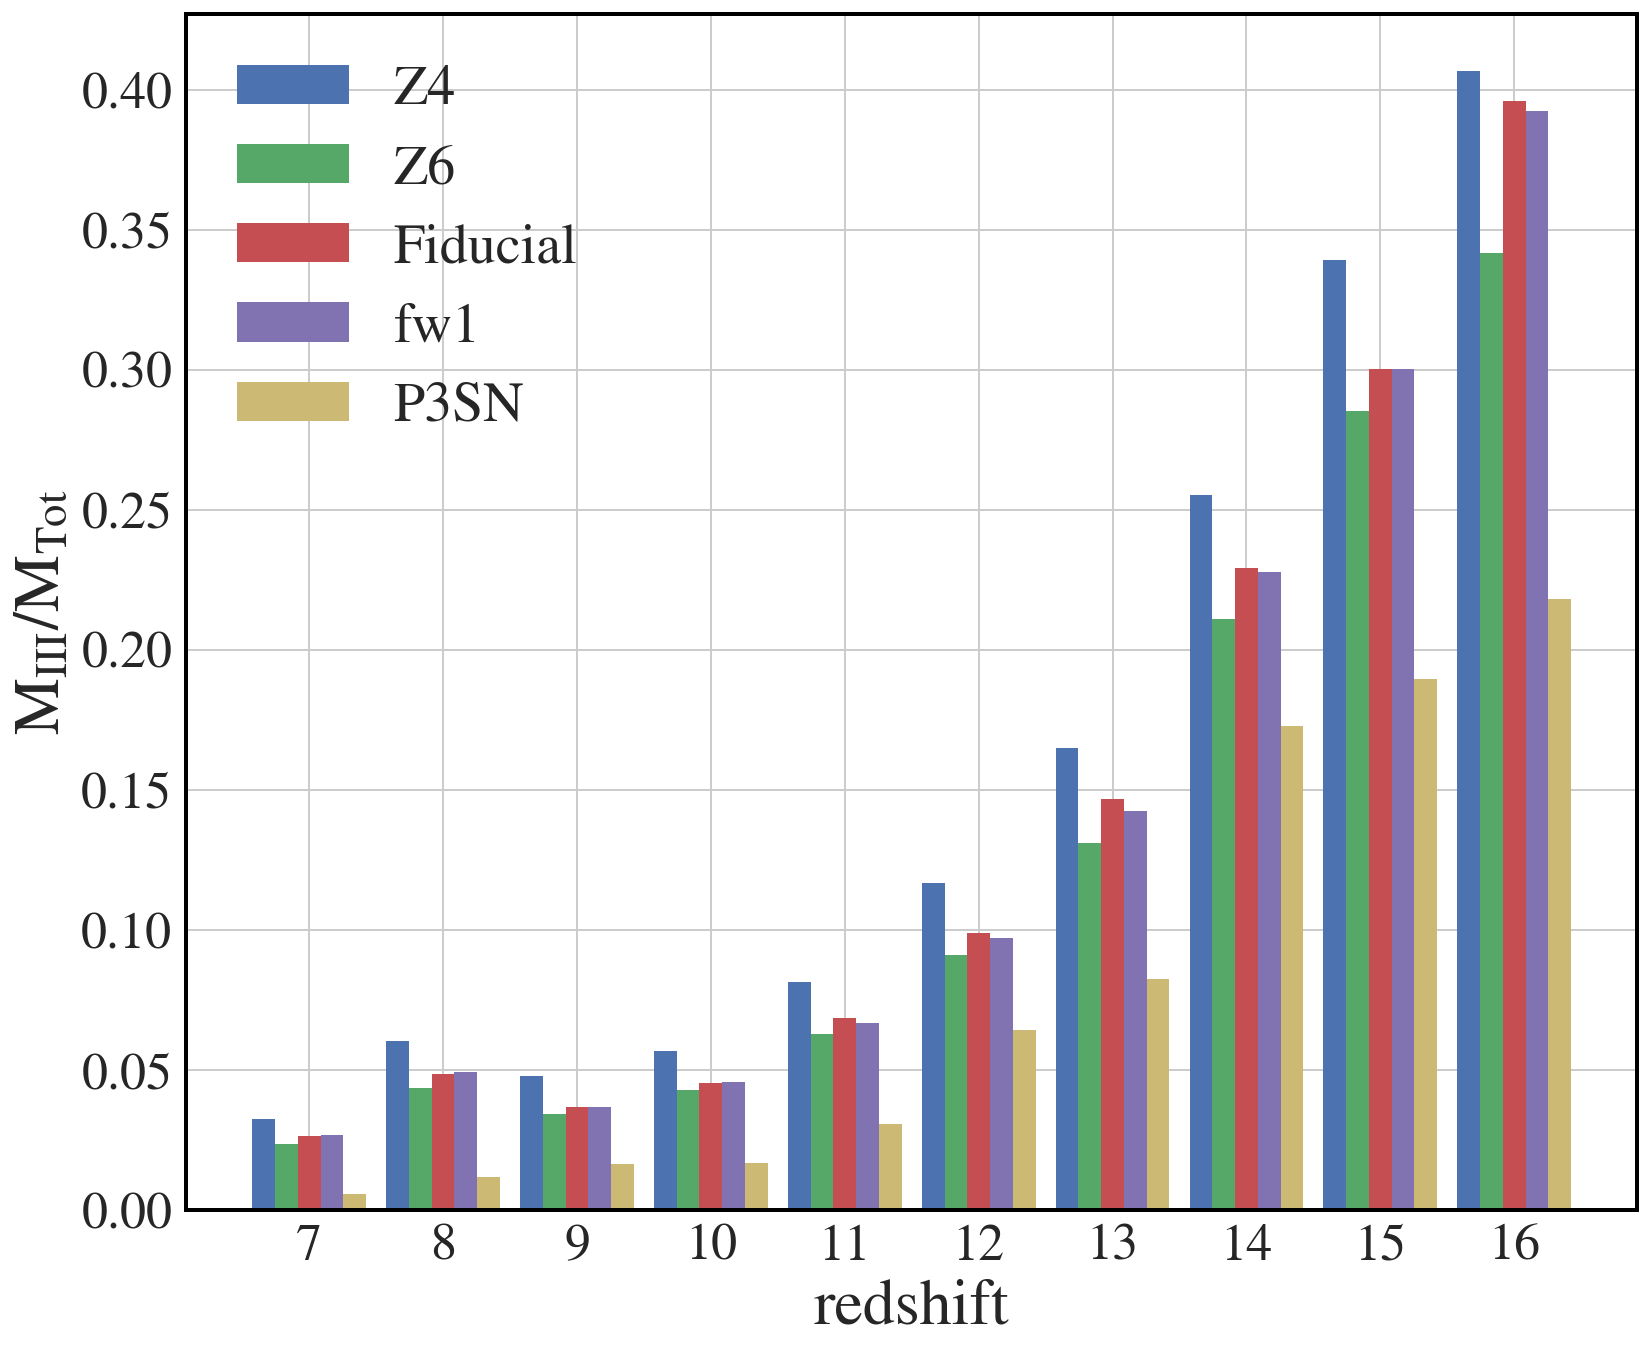

In [32]:
# Pop III stellar mass compared to all stars at each z

bar_width = 0.17

j=-2
for dir in sorted(data_set_names.keys()):
    plt.bar([i+ j*bar_width for i in sorted(haloData[dir].keys())],
         [haloData[dir][i]['M3StarMsun'].sum() / haloData[dir][i]['MstarMsun'].sum() for i in sorted(haloData[dir].keys())],
       bar_width,label=data_set_names[dir])
    j += 1
    
plt.ylabel('$\mathrm{M_{III}/M_{Tot}}$',fontsize=32)
plt.xlabel('redshift',fontsize=32)
plt.xticks([7,8,9,10,11,12,13,14,15,16],fontsize=26)
plt.yticks(fontsize=26)
plt.legend(fontsize=28)
plt.savefig("StellarMass.pdf",bbox_inches='tight')

In [36]:
p3,sm = pop3_mass_frac(p3mf,runs,0.90)

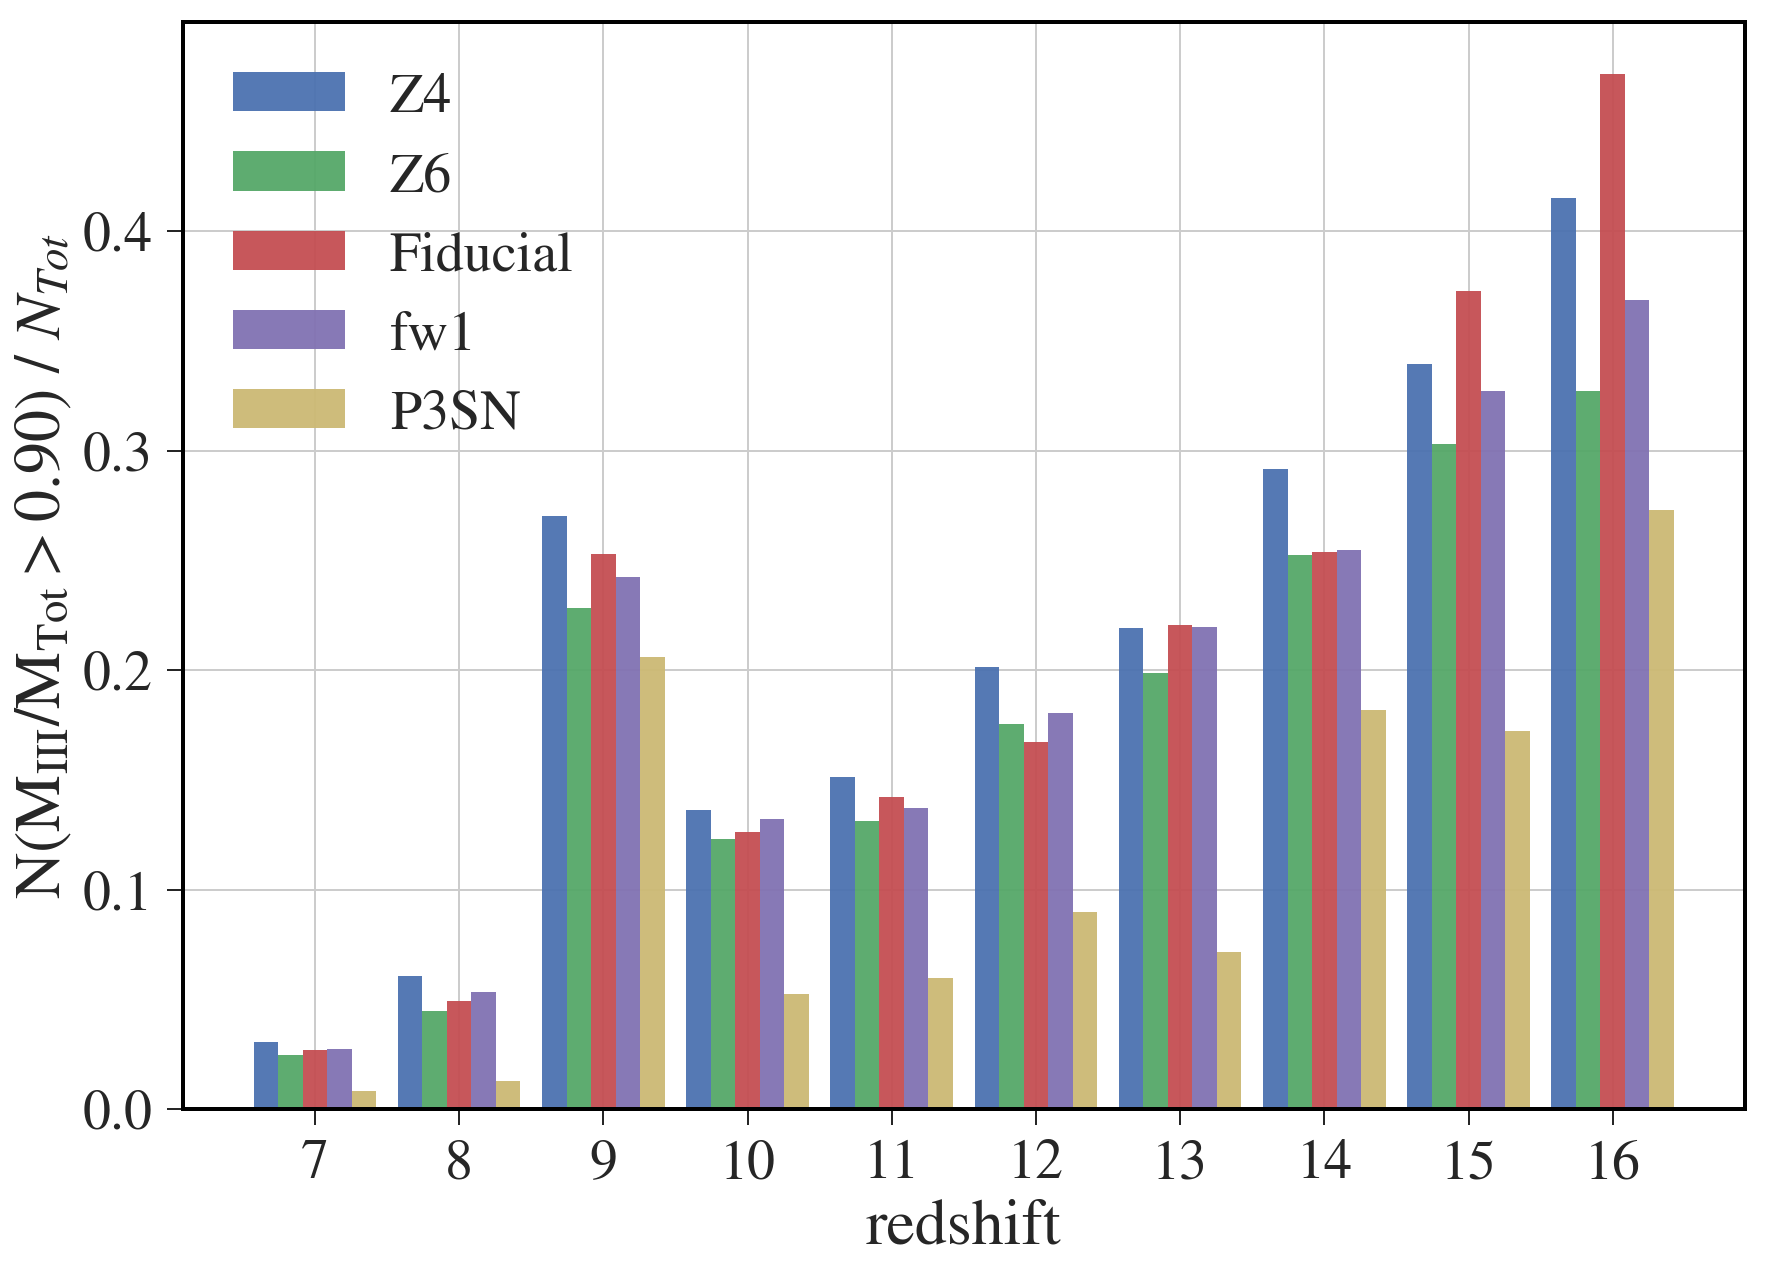

In [37]:
# Fraction of halos dominated by Pop III stars, by mass (> .9)
fig,ax  = plt.subplots(figsize=(14,10))
bar_width = 0.17

j=-2
theFracts={}
for dir in sorted(data_set_names.keys()):
    ax.bar([i+ j*bar_width for i in sorted(haloData[dir].keys())],
         [p3[dir][0][i]/p3[dir][1][i] for i in sorted(haloData[dir].keys())], 
       bar_width,label=data_set_names[dir],alpha=0.95)
    j += 1
    theFracts[dir] = [p3[dir][0][i]/p3[dir][1][i] for i in sorted(haloData[dir].keys())]

# theMean = np.array([np.array([theFracts[dir][z-7] for dir in data_set_names.keys()]).mean() for z in [7,8,9,10,11,12,13,14,15,16]])
    
# ax.plot([7,8,9,10,11,12,13,14,15,16],theMean,'o-', color='#34495e', lw=3.5,
#          markeredgewidth=2.0,markerfacecolor='w',markersize=8, alpha=0.95,label="Mean")
    
ax.xaxis.set_tick_params(which='major',width=1,length=8,direction='out',labelsize=28)
ax.yaxis.set_tick_params(which='major',width=1,length=8,direction='out',labelsize=28)

ax.set_ylabel('$\mathrm{N(M_{III}/M_{Tot} > 0.90)}$ / $N_{Tot}$',fontsize=32)
ax.set_xlabel('redshift',fontsize=32)
ax.set_xticks([7,8,9,10,11,12,13,14,15,16])
# ax.set_yticks(fontsize=24)
ax.legend(fontsize=28)
plt.savefig("P3HaloFrac.pdf",bbox_inches='tight')

In [38]:
p3,sm = pop3_mass_frac(p3mf,runs,0.75)

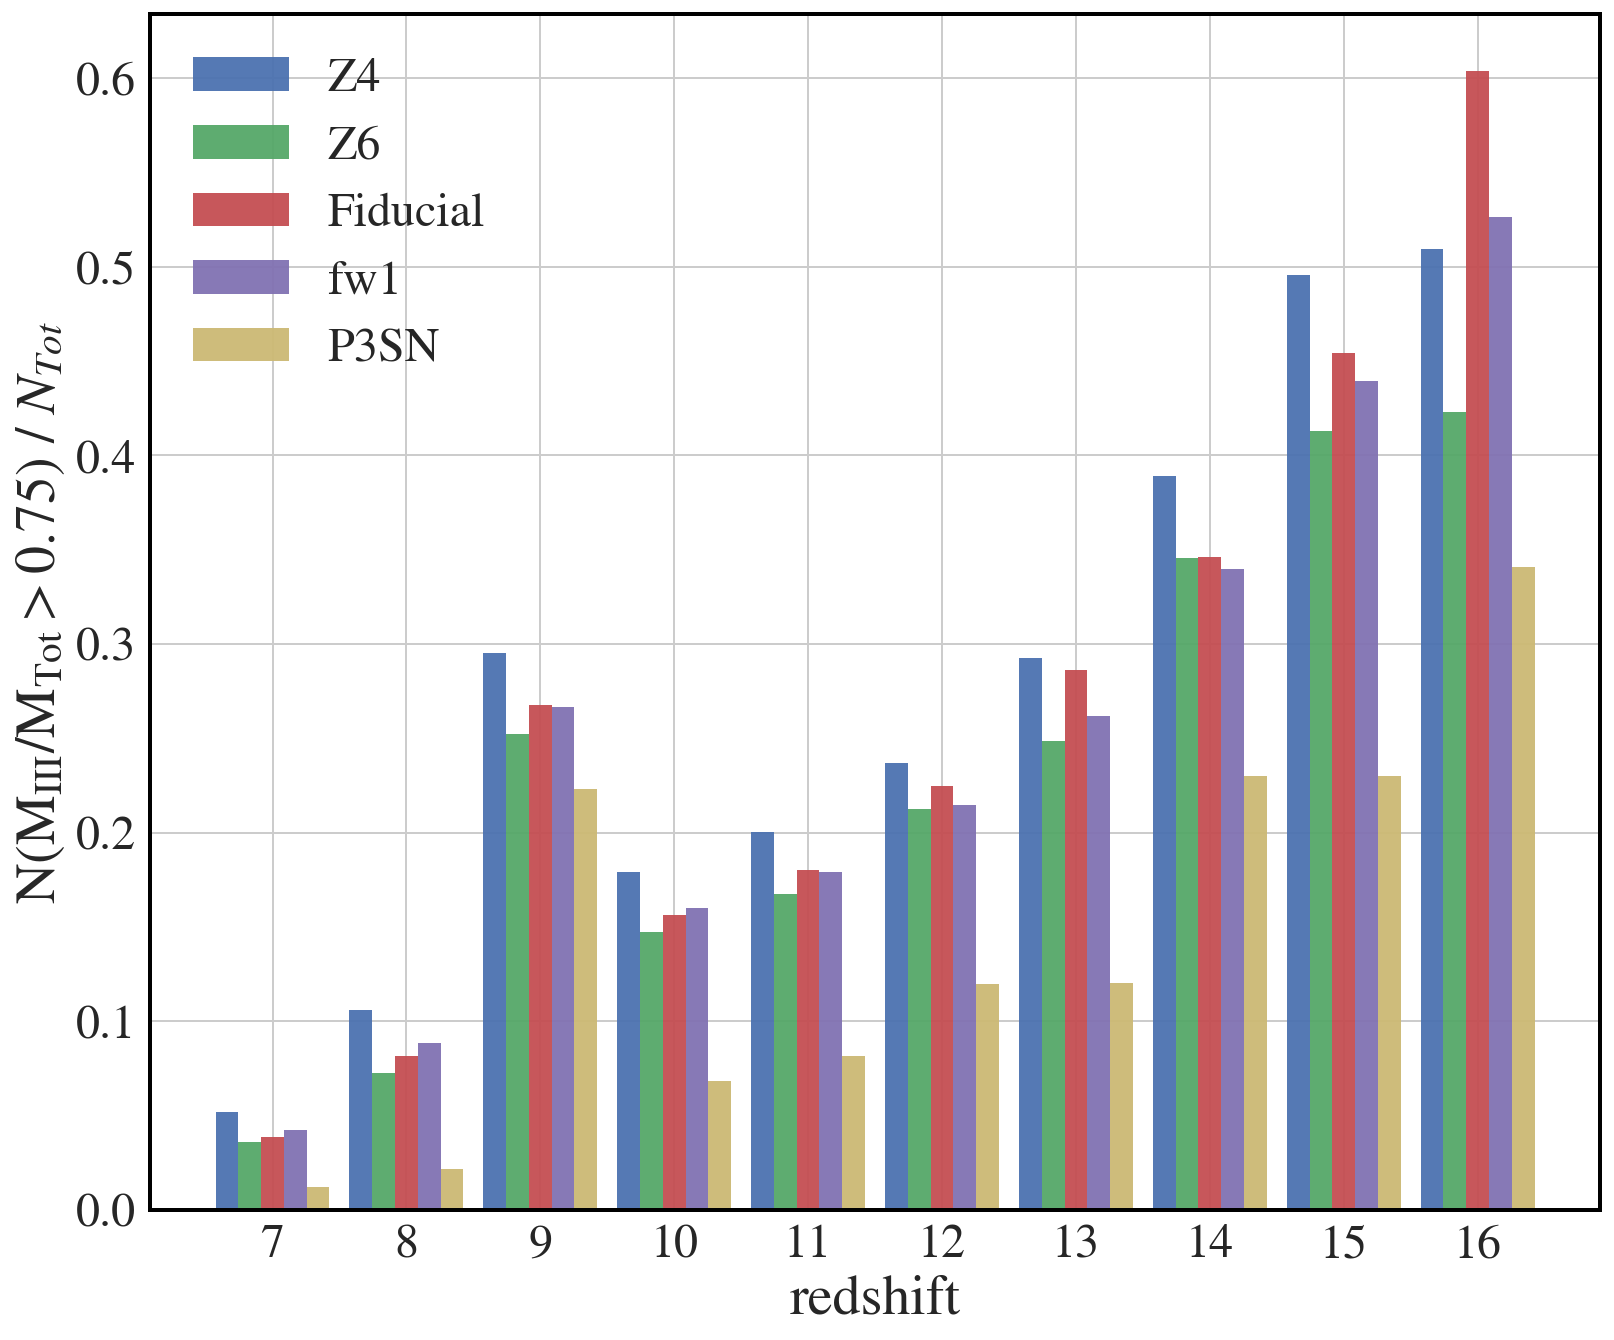

In [39]:
# Fraction of halos dominated by Pop III stars, by mass (> .9)
bar_width = 0.17

j=-2
theFracts={}
for dir in sorted(data_set_names.keys()):
    plt.bar([i+ j*bar_width for i in sorted(haloData[dir].keys())],
         [p3[dir][0][i]/p3[dir][1][i] for i in sorted(haloData[dir].keys())], 
       bar_width,label=data_set_names[dir],alpha=0.95)
    j += 1
    theFracts[dir] = [p3[dir][0][i]/p3[dir][1][i] for i in sorted(haloData[dir].keys())]

# theMean = np.array([np.array([theFracts[dir][z-7] for dir in data_set_names.keys()]).mean() for z in [7,8,9,10,11,12,13,14,15,16]])
    
# plt.plot([7,8,9,10,11,12,13,14,15,16],theMean,'o-', color='#34495e', lw=5, 
#          markeredgewidth=2.0,markerfacecolor='w',markersize=10, alpha=0.95,label="Mean")
    
plt.ylabel('$\mathrm{N(M_{III}/M_{Tot} > 0.75)}$ / $N_{Tot}$',fontsize=28)
plt.xlabel('redshift',fontsize=28)
plt.xticks([7,8,9,10,11,12,13,14,15,16],fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=24)
plt.savefig("P3HaloFrac-75.pdf",bbox_inches='tight')

In [40]:
p39,sm9 = pop3_mass_frac(p3mf,runs,0.9)
p375,sm75 = pop3_mass_frac(p3mf,runs,0.75)
p35,sm5 = pop3_mass_frac(p3mf,runs,0.5)

In [41]:
#
# Find the average mass of Halos with M_III/M > 0.9 before and after reionization
#

p3_typical_mass_fid_z10 = haloData['fid'][10]['MstarMsun'][p3mf['fid'][10] > 0.9]
p3_typical_mass_fid_z9 = haloData['fid'][9]['MstarMsun'][p3mf['fid'][9] > 0.9]
p3_typical_mass_fid_z8 = haloData['fid'][8]['MstarMsun'][p3mf['fid'][8] > 0.9]
p3_typical_mass_fid_z7 = haloData['fid'][7]['MstarMsun'][p3mf['fid'][7] > 0.9]


# Plot histogram of Pop III halos before & after reionization

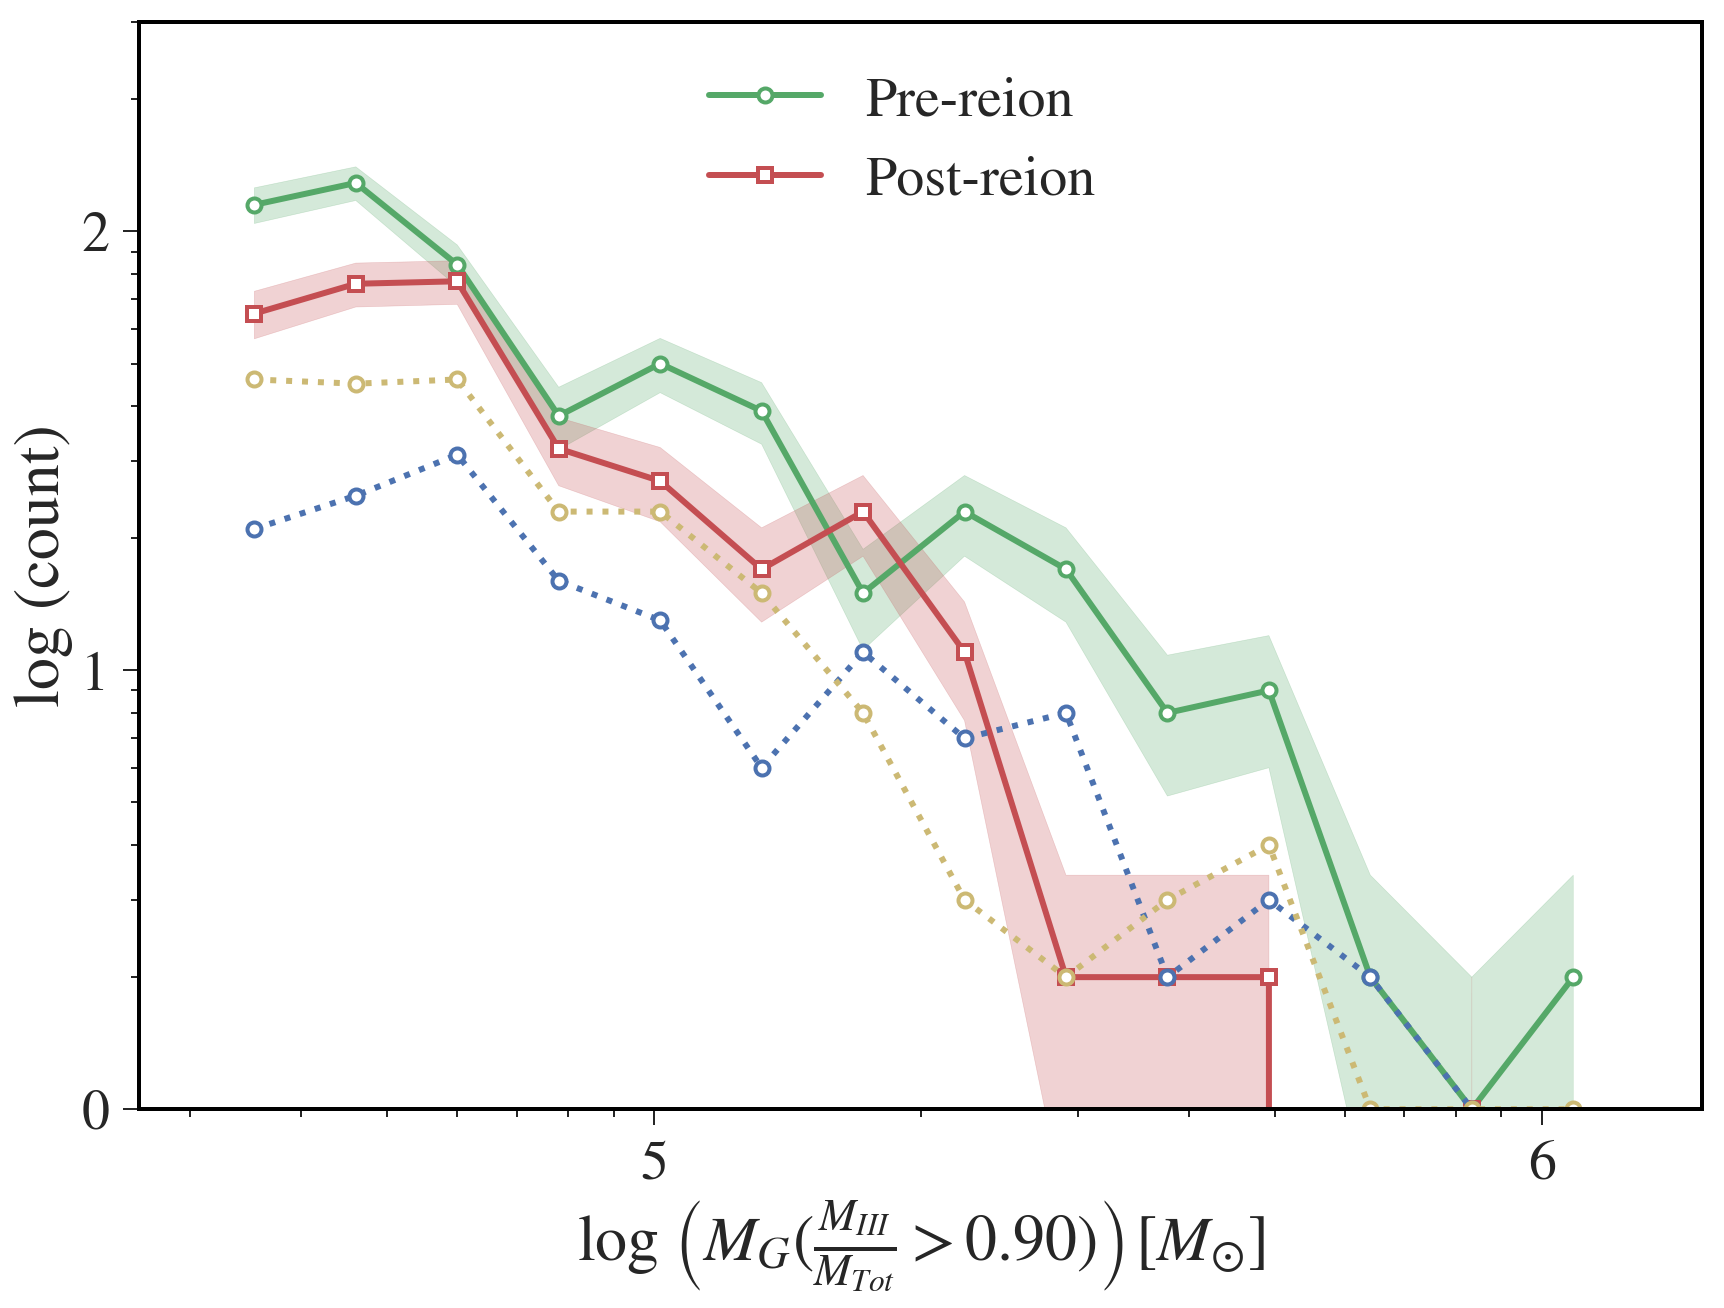

In [42]:
# mpl.style.use('default')
from pylab import *

fig,ax  = plt.subplots(figsize=(14,10))
theBins = np.logspace(4.5,6.1,15)
diffs = np.diff(theBins)

# n,bins,patches = ax.hist([p3_typical_mass_fid_z10,p3_typical_mass_fid_z9,p3_typical_mass_fid_z8,p3_typical_mass_fid_z7], #,weights=1.0/(12/0.71)**3,
#                           bins=theBins,log=True,color=['C0','C1','C2','C3'], label=['$z=10$','$z=9$','$z=8$','$z=7$'],
#                          lw=3, linestyle=(':','-','-',':'),
#                          alpha=0.85, histtype='step')

n107,bins,patches = ax.hist([p3_typical_mass_fid_z10,p3_typical_mass_fid_z7], #,weights=1.0/(12/0.71)**3,
                          bins=theBins,log=True,color=['C0','C4'], #label=['$z=10$','$z=7$'],
                         lw=3, linestyle=':', #fill=True,
                         alpha=0.0, histtype='step')
# n[0] is z9, n[1] is z[8]
n,bins,patches = ax.hist([p3_typical_mass_fid_z9,p3_typical_mass_fid_z8], #,weights=1.0/(12/0.71)**3,
                          bins=theBins,log=True,color=['C1','C2'], #label=['$z=9$','$z=8$'],
                         lw=2, fill=True,
                         alpha=0.0, histtype='step')

# ax.errorbar(bins[:-1]+bins[:-1]*0.121,n[1],yerr=np.sqrt(n[1]),fmt='o--C1', mec='C1', markeredgewidth=2.0,
#             markerfacecolor='w',ecolor='k', capsize=4, capthick=1, label='Pre-reion')
# ax.fill_between(bins[:-1]+bins[:-1]*0.121,n[1]-np.sqrt(n[1]),n[1]+np.sqrt(n[1]), color='C1' ,alpha=0.25)

# ax.errorbar(bins[:-1]+bins[:-1]*0.121,n[2],yerr=np.sqrt(n[2]),fmt='s--C2', mec='C2', markeredgewidth=2.0,
#             markerfacecolor='w' ,ecolor='k', capsize=4, capthick=1, label='Post-reion')
# ax.fill_between(bins[:-1]+bins[:-1]*0.121,n[2]-np.sqrt(n[2]),n[2]+np.sqrt(n[2]), color='C2' ,alpha=0.25)

# ax.errorbar(bins[:-1]+bins[:-1]*0.121,n[0],yerr=np.sqrt(n[0]),fmt='o--C1', mec='C1', markeredgewidth=2.0,
#             markerfacecolor='w',ecolor='k', capsize=4, capthick=1, label='Pre-reion')
ax.plot(bins[:-1]+bins[:-1]*0.121,n[0],'o-C1', mec='C1', markeredgewidth=2.0, lw=3,
            markerfacecolor='w',label='Pre-reion')
ax.fill_between(bins[:-1]+bins[:-1]*0.121,n[0]-np.sqrt(n[0]),n[0]+np.sqrt(n[0]), color='C1' ,alpha=0.25)

# ax.errorbar(bins[:-1]+bins[:-1]*0.121,n[1],yerr=np.sqrt(n[1]),fmt='s--C2', mec='C2', markeredgewidth=2.0,
#             markerfacecolor='w' ,ecolor='k', capsize=4, capthick=1, label='Post-reion')
ax.plot(bins[:-1]+bins[:-1]*0.121,n[1],'s-C2', mec='C2', markeredgewidth=2.0, lw=3,
            markerfacecolor='w' ,label='Post-reion')
ax.fill_between(bins[:-1]+bins[:-1]*0.121,n[1]-np.sqrt(n[1]),n[1]+np.sqrt(n[1]), color='C2' ,alpha=0.25)

ax.plot(bins[:-1]+bins[:-1]*0.121,n107[0],'o:C0', mec='C0', markeredgewidth=2.0, lw=3,
            markerfacecolor='w',label='z=10')
ax.plot(bins[:-1]+bins[:-1]*0.121,n107[1],'o:C4', mec='C4', markeredgewidth=2.0, lw=3,
            markerfacecolor='w',label='z=7')

handles,labels = ax.get_legend_handles_labels()

handles2 = [handles[0], handles[1]]
labels2  = [labels[0], labels[1]]

# handles = [ handles[2], handles[3], handles[4], handles[5]]
# labels = [ labels[2], labels[3], labels[4],labels[5]]

ax.set_xscale('log')  
# plt.yscale('log')
ax.set_ylim([1,3e2])
ax.set_xlabel(r'log $\left(M_{G}(\frac{M_{III}}{M_{Tot}} > 0.90)\right)\,[M_{\odot}]$',fontsize=32)
ax.set_ylabel('log (count)',fontsize=32)
ax.grid()
ax.xaxis.set_major_formatter(logfmt)
ax.yaxis.set_major_formatter(logfmt)
ax.xaxis.set_tick_params(which='major',width=1,length=8,direction='out',labelsize=28)
ax.xaxis.set_tick_params(which='minor',width=1,length=4,direction='out',labelsize=28)
ax.yaxis.set_tick_params(which='major',width=1,length=8,direction='out',labelsize=28)
ax.yaxis.set_tick_params(which='minor',width=1,length=4,direction='out')
# ax.tick_params(width=1,length=6,which='major')
ax.yaxis.set_tick_params(width=1,length=4,which='minor')
# l1 = ax.legend(handles, labels, fontsize=28)
ax.legend(loc=(0.35,.81),handles=handles2, labels=labels2, fontsize=28)
# gca().add_artist(l1)
plt.savefig("H3HaloMass.pdf",dpi=fig.dpi, bbox_inches='tight')

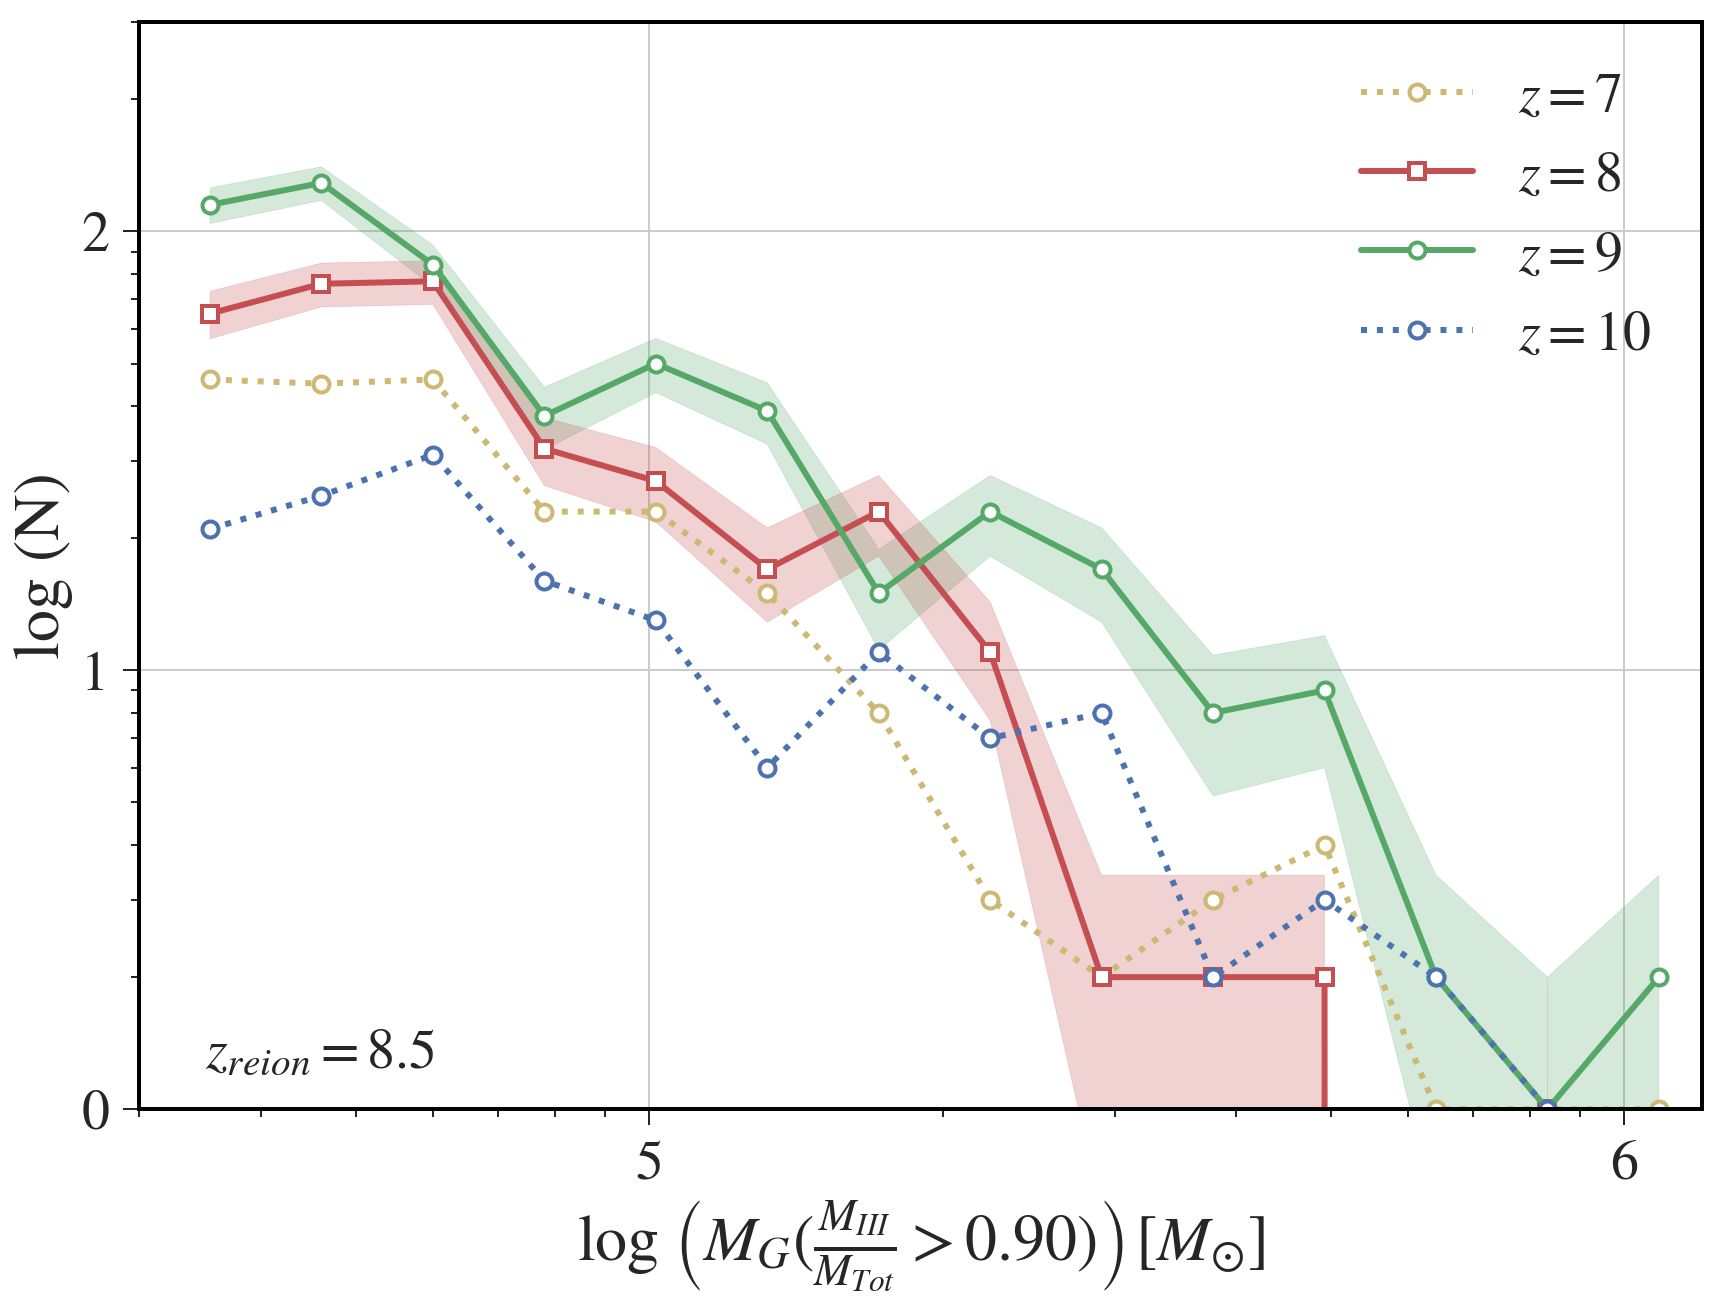

In [44]:
# mpl.style.use('default')
from pylab import *

fig,ax  = plt.subplots(figsize=(14,10))
theBins = np.logspace(4.5,6.1,15)
diffs = np.diff(theBins)

# n,bins,patches = ax.hist([p3_typical_mass_fid_z10,p3_typical_mass_fid_z9,p3_typical_mass_fid_z8,p3_typical_mass_fid_z7], #,weights=1.0/(12/0.71)**3,
#                           bins=theBins,log=True,color=['C0','C1','C2','C3'], label=['$z=10$','$z=9$','$z=8$','$z=7$'],
#                          lw=3, linestyle=(':','-','-',':'),
#                          alpha=0.85, histtype='step')

n107,bins,patches = ax.hist([p3_typical_mass_fid_z10,p3_typical_mass_fid_z7], #,weights=1.0/(12/0.71)**3,
                          bins=theBins,log=True,color=['C0','C4'], #label=['$z=10$','$z=7$'],
                         lw=3, linestyle=':', #fill=True,
                         alpha=0.0, histtype='step')
# n[0] is z9, n[1] is z[8]
n,bins,patches = ax.hist([p3_typical_mass_fid_z9,p3_typical_mass_fid_z8], #,weights=1.0/(12/0.71)**3,
                          bins=theBins,log=True,color=['C1','C2'], #label=['$z=9$','$z=8$'],
                         lw=2, fill=True,
                         alpha=0.0, histtype='step')

ax.plot(bins[:-1]+bins[:-1]*0.121,n107[1],'o:C4', mec='C4', markeredgewidth=2.0, lw=3, ms=8,
            markerfacecolor='w',label='$z=7$')

ax.plot(bins[:-1]+bins[:-1]*0.121,n[1],'s-C2', mec='C2', markeredgewidth=2.0, lw=3,ms=8,
            markerfacecolor='w' ,label='$z=8$')

ax.plot(bins[:-1]+bins[:-1]*0.121,n[0],'o-C1', mec='C1', markeredgewidth=2.0, lw=3,ms=8,
            markerfacecolor='w',label='$z=9$')

ax.plot(bins[:-1]+bins[:-1]*0.121,n107[0],'o:C0', mec='C0', markeredgewidth=2.0, lw=3,ms=8,
            markerfacecolor='w',label='$z=10$')

ax.fill_between(bins[:-1]+bins[:-1]*0.121,n[0]-np.sqrt(n[0]),n[0]+np.sqrt(n[0]), color='C1' ,alpha=0.25)

ax.fill_between(bins[:-1]+bins[:-1]*0.121,n[1]-np.sqrt(n[1]),n[1]+np.sqrt(n[1]), color='C2' ,alpha=0.25)

ax.annotate('$z_{reion}=8.5$', xy=(3.5e4, 100), xytext=(3.5e4, 1.25), fontsize=28 )
ax.set_xscale('log')  
# plt.yscale('log')
ax.set_xlim([3e4,1.2e6])
ax.set_ylim([1,3e2])
ax.set_xlabel(r'log $\left(M_{G}(\frac{M_{III}}{M_{Tot}} > 0.90)\right)\,[M_{\odot}]$',fontsize=32)
ax.set_ylabel('log (N)',fontsize=32)
# ax.grid()
ax.xaxis.set_major_formatter(logfmt)
ax.yaxis.set_major_formatter(logfmt)
ax.xaxis.set_tick_params(which='major',width=1,length=8,direction='out',labelsize=28)
ax.xaxis.set_tick_params(which='minor',width=1,length=4,direction='out',labelsize=28)
ax.yaxis.set_tick_params(which='major',width=1,length=8,direction='out',labelsize=28)
ax.yaxis.set_tick_params(which='minor',width=1,length=4,direction='out')
# ax.tick_params(width=1,length=6,which='major')
ax.yaxis.set_tick_params(width=1,length=4,which='minor')
ax.legend(loc=0, fontsize=28)
plt.savefig("H3HaloMass.pdf",dpi=fig.dpi, bbox_inches='tight')

In [48]:
np.log10(34000)

4.5314789170422554